IMPORTING STUFFS


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


FUNCTION TO PLOT GIVEN SERIES

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end],format,label=label) 
  
  plt.xlabel="Time"
  plt.ylabel="Value"

  if label :
    plt.legend()

  plt.grid(True)

SOME FUNCTIONS TO GENERATE A FAKE TIME SERIES

In [3]:
def trend(time,slope=0):
  return slope*time

In [4]:
def season_pattern(season_time):
  return np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time)) 

def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time+phase)%period)/period*1.0
  return amplitude*season_pattern(season_time)

In [5]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Let us generate Time Series with these functions

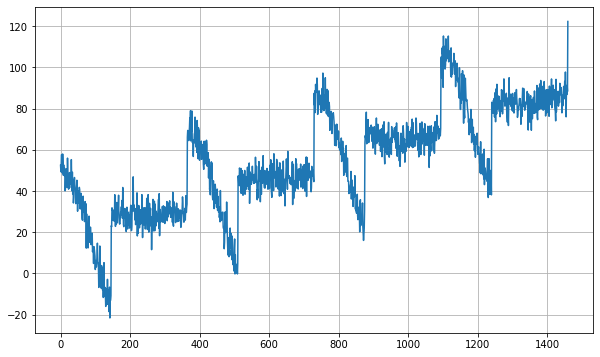

In [6]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

-> We will use the model to forecast one step given previous 30 steps

In [7]:
# --- we define a function which takes simple numpy array as input and convert it into the required format --- #
# --- we always need to convert it in the format, the tf model supports -- #
# --- In this, we need to have a single test case as :
# --- Input : [x1,x2,x3,...,x30] | output [x31]
# --- So first convert it into window of size 31 and then divide it into two parts, one for input and other for output
# --- We must use tensorflow dataset format, as our model understands it

def window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):

  dataset = tf.data.Dataset.from_tensor_slices(series) #takes np array as input and converts it into tf data objects
  dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)  #windows of size window_size is created
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1)) #all elements within a window is now batched together
                                                                          #flat_map do the map function to the each nested element
                                                                          #lambda is a single expression function which is in this case taking 
                                                                          #window as argument and returning its batch which in turn getting mapped

                                                                          #By using batch function, a new dimension is added to each component representing the batch_size

  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window : (window[:-1],window[-1])  )       #first part is input and the later one is output for the training purpose
  dataset = dataset.batch(batch_size).prefetch(1) 
  
  return dataset

-> Dividing the time and series(value) into training and validation datasets

In [8]:
split_time = 1000 #Let the first 1000 days be for the training purpose and the rest be for the validation purpose

train_time = time[:split_time]
train_series = series[:split_time]

val_time = time[split_time:]
val_series = series[split_time:]

-> Getting the required format of data

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Seed just help the random function of python to get started as it requires a number to start with, in order to generate any random number

WINDOW_SIZE = 30 

train_dataset = window_dataset(train_series,WINDOW_SIZE)
val_dataset = window_dataset(val_series,WINDOW_SIZE)


A. Simple CNN 

In [ ]:
model = tf.keras.Sequential([
          tf.keras.layers.Dense(10,activation='relu',input_shape=[WINDOW_SIZE]),
          tf.keras.layers.Dense(10,activation='relu'),
          tf.keras.layers.Dense(1)
])

# --- now do the compile and fit stuffs --- #

#optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.Huber(),
    metrics=['mae','accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
bm = tf.keras.callbacks.ModelCheckpoint('best_model_Time.h5')

model.fit(train_dataset, epochs=400,
          validation_data=val_dataset,
          callbacks=[early_stopping,bm])

model = tf.keras.models.load_model('best_model_Time.h5')

Define a forecast function which would predict the next step, given 30 steps

In [124]:
def model_forecast(model,series,window_size,batch_size=32,Shift=1):

  ds = tf.data.Dataset.from_tensor_slices(series) 
  ds = ds.window(window_size,shift=Shift,drop_remainder=True)

  ds = ds.flat_map(lambda window : window.batch(window_size))

  ds = ds.batch(batch_size).prefetch(1) 

  result = model.predict(ds) 

  return result

Now forcasting the validation set and comparing it with the actual value

In [48]:
forecast = model_forecast(model, series[split_time-WINDOW_SIZE:-1] ,WINDOW_SIZE)
forecast = forecast.flatten()
forecast.shape

(1651,)

GRAPH VISUAL

In [ ]:
plt.plot(val_time,forecast,label='Predicted')
plt.plot(val_time,val_series,label='Actual')
plt.legend()

B. SIMPLE RNN AND SEQUENCE TO VECTOR PREDICTION

In [ ]:
model = tf.keras.Sequential([
          tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None] ), #Except the batch and the input dimension, Simple RNN expects a third "feature" dimension, so we are adding a layer before it which takes care of that extra dimension
                                                                                            # None Input Shape means it can take any size of input, and that's the advantage of RNN
          tf.keras.layers.SimpleRNN(100,activation='tanh',return_sequences=True) ,
          tf.keras.layers.SimpleRNN(110,activation='tanh',return_sequences=False) ,
          
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x:x*215) #becuase we have used tanh function, it is a good practice to multiply the result by a factor of 200
])

model.compile(
    optimizer = 'adam',
    loss =  tf.keras.losses.Huber(),
    metrics = ['mae']
)

es = tf.keras.callbacks.EarlyStopping(patience=10) 
bm = tf.keras.callbacks.ModelCheckpoint('best_model_SimpleRnn.h5',save_best_only=True)

model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=[es,bm] 
)

model = tf.keras.models.load_model('best_model_SimpleRnn.h5')

In [ ]:
#-- Predicting

forecast = model_forecast(model,series[split_time-WINDOW_SIZE:-1],WINDOW_SIZE)
forecast = forecast.flatten()

plt.figure(figsize=(66,30))
plt.plot(val_time,forecast,label='Predicted')
plt.plot(val_time,val_series,label='Actual')
plt.legend()

C. SIMPLE RNN : SEQUENCE TO SEQUENCE PREDICTION

In [137]:
#we need to re-define/create new window_dataset function, as we now want the output to be a sequence as well.
def window_dataset_seq2seq(series,window_size,batch_size=32,shuffle_buffer=1000,Shift=1):

  series = tf.expand_dims(series, axis=-1) #It would avoid the extra Lambda layer, we used for maintaining the input size in the layer of Simple RNN
  
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size+1,shift=Shift,drop_remainder=True)

  ds=ds.flat_map(lambda window:window.batch(window_size+1))
  
  if batch_size != 1 :
    ds=ds.shuffle(shuffle_buffer) # because when batch_size == 1 ,it means we are using LSTM, and hence , we don't want reshuffling in it. Because in it, we are remembering the old data as well, and hence the order of timestamps is important

  ds=ds.map(lambda window:(window[:-1],window[1:]) )

  ds = ds.batch(batch_size).prefetch(1) 
  
  return ds

In [ ]:
# create new train_datset and val_datset
# we already have train_time,val_time,train_series,val_series,split_time
# only train_dataset and val_dataset needs to be updated

train_dataset=window_dataset_seq2seq(train_series,WINDOW_SIZE,batch_size=128)
val_dataset=window_dataset_seq2seq(val_series,WINDOW_SIZE,batch_size=128)

model = tf.keras.Sequential([
            tf.keras.layers.SimpleRNN(100,activation='tanh',return_sequences=True,input_shape=[None,1]),
            tf.keras.layers.SimpleRNN(100,activation='tanh',return_sequences=True),

            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x:x*210)
])

optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9)

model.compile(
    optimizer=optimizer, #this optmizer performed reallty much better than adam, so while making the final model we can always look for this SGD optimizer, and we have a callback function to better under what lr we should select
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

es=tf.keras.callbacks.EarlyStopping(patience=20)
bm=tf.keras.callbacks.ModelCheckpoint('model_seq2seq_SIMPLE_RNN.h5',save_best_only=True)

model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=[es,bm]
)


model=tf.keras.models.load_model('model_seq2seq_SIMPLE_RNN.h5')

Now prediction + Graph

In [ ]:
forecast = model_forecast(model,series[...,np.newaxis],WINDOW_SIZE)
# the model would return the prediction for each possible window and each output would be of size 30 and the returned forecast would have an extra dimesion at the end as well
# forecast shape = (1432,30,1)
# hence the first dimension is for each window, and for each window we have a prediction of 30 size 
# atlast, we would extract out the required validation set series windows, and we would take the last element from each predicted window, and would ignore the last dimensiona as usual


forecast = forecast[split_time-WINDOW_SIZE:-1,-1]
forecase = forecast.flatten()


plt.figure(figsize=(66,30))
plt.plot(val_time,forecast,label='Predicted')
plt.plot(val_time,val_series,label='Actual')
plt.legend()

There is a stateful SimpleRNN as well, in which we don't shuffle the windows which helps it to remember the patter for much longer time than just the window_size

But unfortunately, it doesn't perform well enough. 

Fortunately, we do have LSTM which would remember the much longer old patterns as well

D. LSTM : we would take batch_size = 1 and need to define our own callback to reset the states after each epoch. ( WIll study about it later )

In [94]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


train_dataset = window_dataset_seq2seq(train_series,WINDOW_SIZE,batch_size=1,Shift=WINDOW_SIZE)
val_dataset = window_dataset_seq2seq(val_series,WINDOW_SIZE,batch_size=1,Shift=WINDOW_SIZE)

#batch size in stateful LSTM is taken as 1 because, we want to process the data in the correct order and not parallely
#we use Shift=Window_size because of the same reason, we want to go in the correct order, without repeating any time


model = tf.keras.Sequential([
          tf.keras.layers.LSTM(100,return_sequences=True,batch_input_shape=[1,None,1],stateful=True), #stateful is what that takes care of previous value
          tf.keras.layers.LSTM(100,return_sequences=True,stateful=True),

          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x : 200*x)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-7,momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

ES = tf.keras.callbacks.EarlyStopping(patience=50)
BM = tf.keras.callbacks.ModelCheckpoint('modelnew.h5',save_best_only=True)
RS = ResetStatesCallback()

model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=[ES,BM,RS]
)

model=tf.keras.models.load_model('modelnew.h5')


Prediction and Graph

In [ ]:
forecast = model_forecast(model,series[...,np.newaxis],WINDOW_SIZE,batch_size=1)

forecast = forecast[split_time-WINDOW_SIZE:-1,-1]
forecase = forecast.flatten()


plt.figure(figsize=(66,30))
plt.plot(val_time,forecast,label='Predicted')
plt.plot(val_time,val_series,label='Actual')
plt.legend()

E. 1D CONVOLUTIONAL LAYER + LSTM(stateless):

In [138]:
#only in stateful LSTM we need to have batch size = 1 and shuffle disable and shift = window size because order matter and reset states
#but in 1-d Convo and stateless LSTM, we do it randomly just the key point is 1-d convo layer searcher for longer pattern using filters whereas stateless LSTM does the same for shorter patterns
train_dataset=window_dataset_seq2seq(train_series,WINDOW_SIZE,128)
val_dataset=window_dataset_seq2seq(val_series,WINDOW_SIZE,128) 

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal", # causal padding is very imp here
                      activation="relu",
                      input_shape=[None, 1]), # it is also input size independent
  keras.layers.LSTM(32, return_sequences=True), #stateless LSTM
  keras.layers.LSTM(32, return_sequences=True), #stateless LSTM
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9) 

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_dataset, epochs=500,
          validation_data=val_dataset,
          callbacks=[early_stopping, model_checkpoint])



Epoch 1/500
8/8 [==============================] - 3s 112ms/step - loss: 25.3499 - mae: 25.8474 - val_loss: 33.0003 - val_mae: 33.4989
Epoch 2/500
8/8 [==============================] - 0s 22ms/step - loss: 18.8139 - mae: 19.3088 - val_loss: 24.6080 - val_mae: 25.1060
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 12.8413 - mae: 13.3326 - val_loss: 17.1192 - val_mae: 17.6134
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 10.8604 - mae: 11.3504 - val_loss: 19.6708 - val_mae: 20.1672
Epoch 5/500
8/8 [==============================] - 0s 22ms/step - loss: 8.7780 - mae: 9.2647 - val_loss: 17.3311 - val_mae: 17.8261
Epoch 6/500
8/8 [==============================] - 0s 21ms/step - loss: 7.9231 - mae: 8.4083 - val_loss: 15.8980 - val_mae: 16.3911
Epoch 7/500
8/8 [==============================] - 0s 22ms/step - loss: 7.3714 - mae: 7.8556 - val_loss: 15.6235 - val_mae: 16.1171
Epoch 8/500
8/8 [==============================] - 0s 22ms/step - l

Prediction + Graph

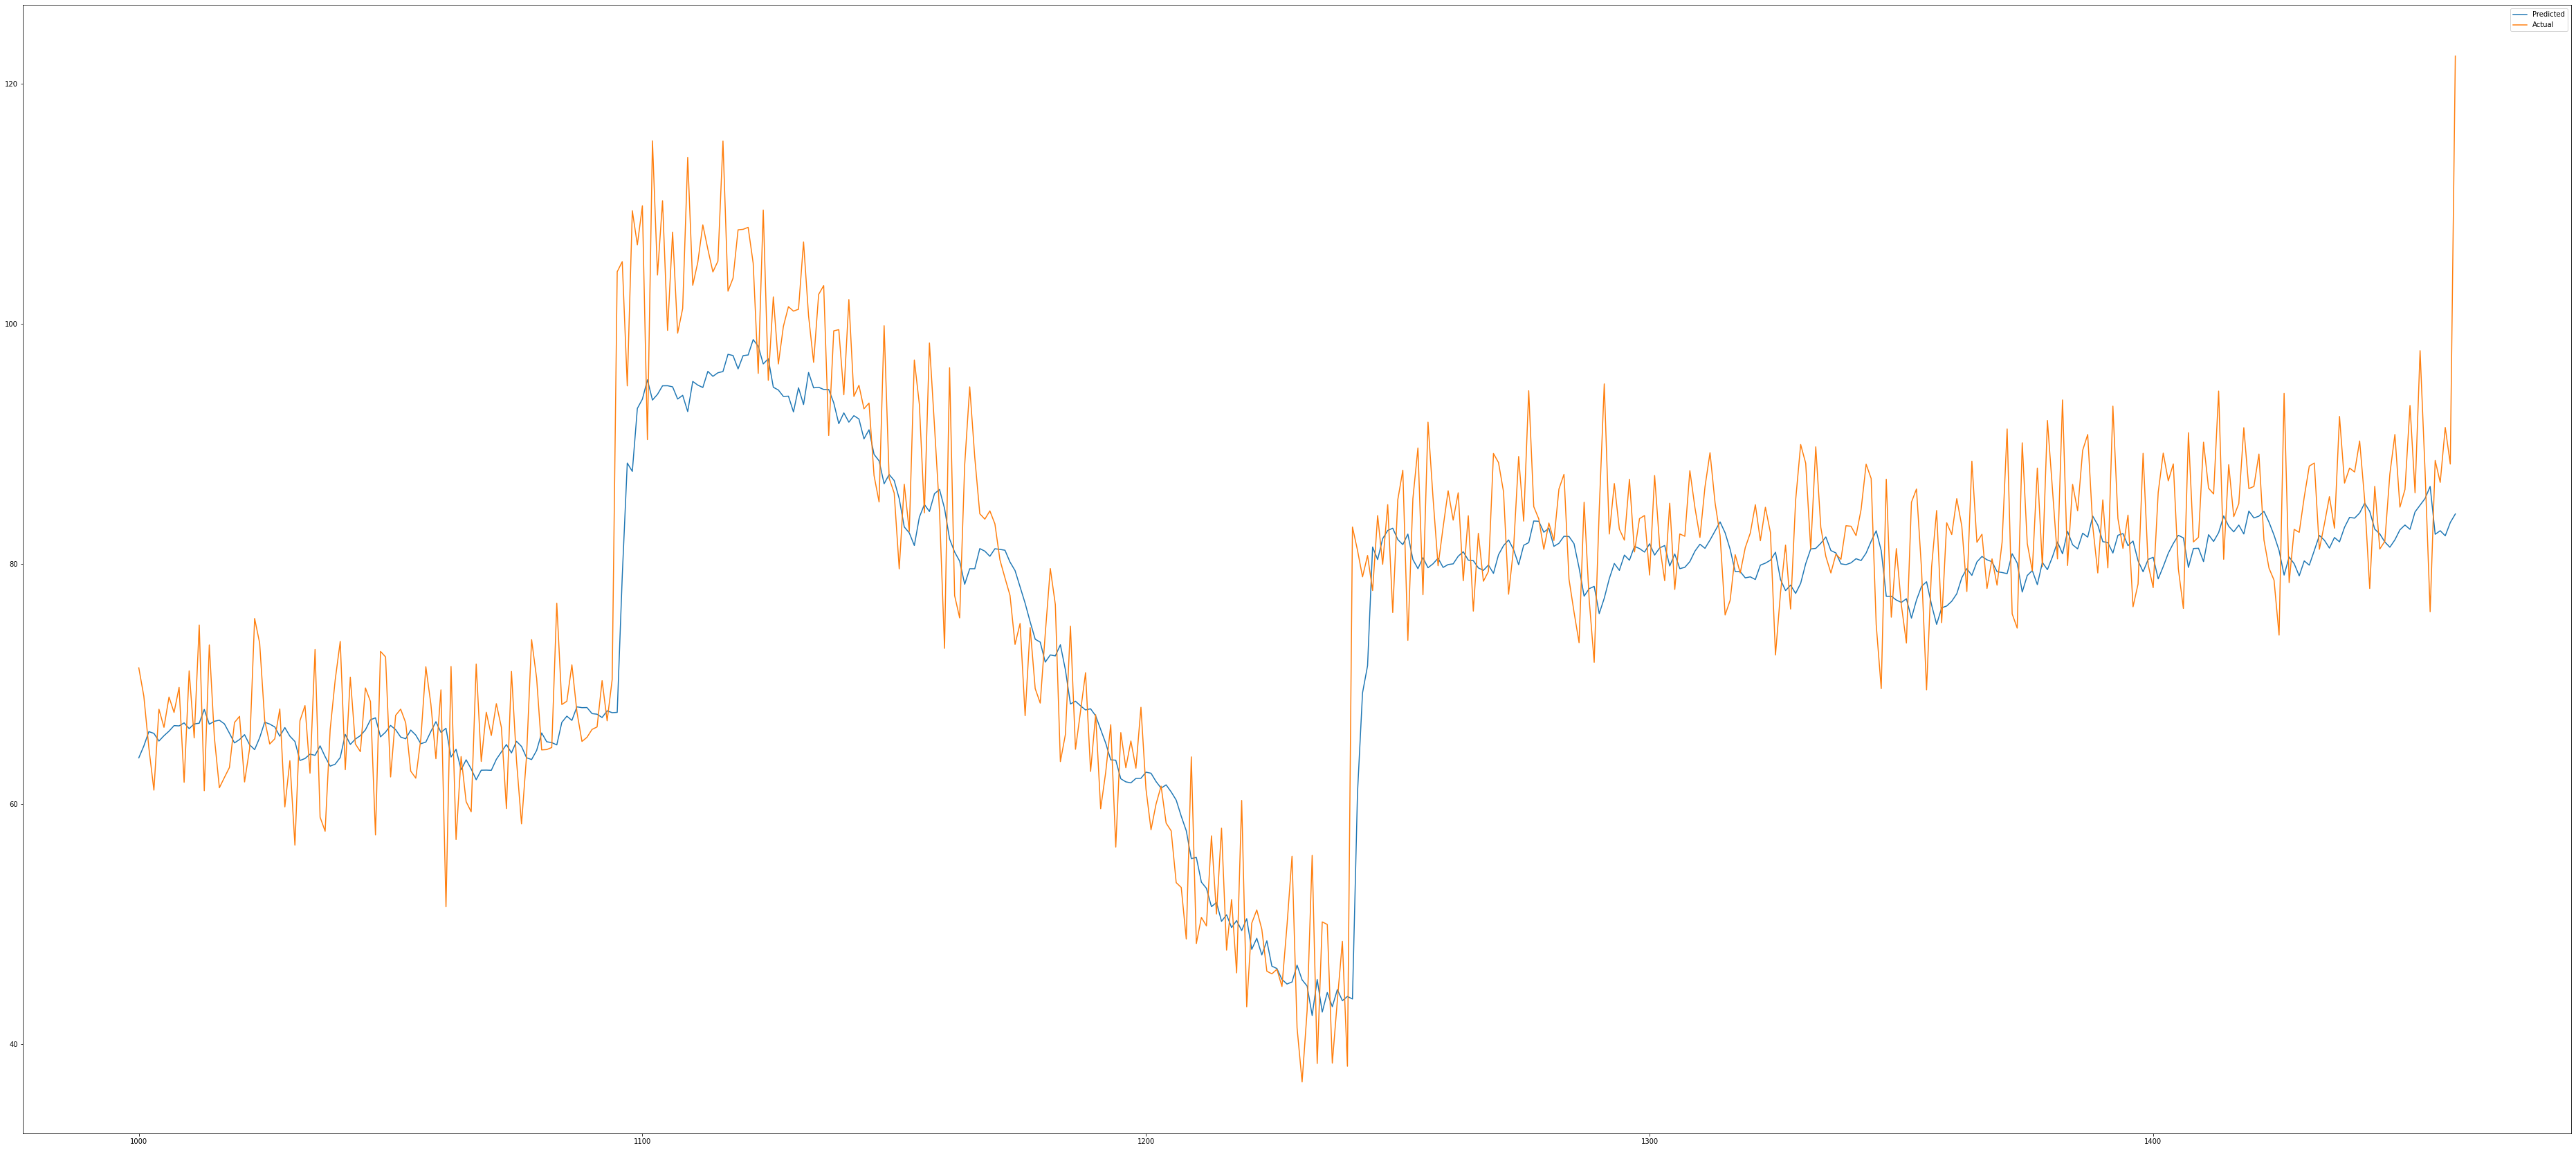

In [139]:
forecast = model_forecast(model,series[...,np.newaxis],WINDOW_SIZE,batch_size=1)

forecast = forecast[split_time-WINDOW_SIZE:-1,-1]
forecase = forecast.flatten()


plt.figure(figsize=(66,30))
plt.plot(val_time,forecast,label='Predicted')
plt.plot(val_time,val_series,label='Actual')
plt.legend()

F. FULLY 1-D CONVO MODEL ||| WAVENET





In [142]:
WINDOW_SIZE=64
train_dataset = window_dataset_seq2seq(train_series,WINDOW_SIZE,batch_size=128)
val_dataset = window_dataset_seq2seq(val_series,WINDOW_SIZE,batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1])) # point to be noted, that input size independent
for dilation_rate in (1, 2, 4, 8, 16, 32): # the dileration rate see the pattern , both long and short term pattens
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1)) #final layer
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, model_checkpoint])

model = tf.keras.models.load_model('my_checkpoint.h5')

Prediction + Graph

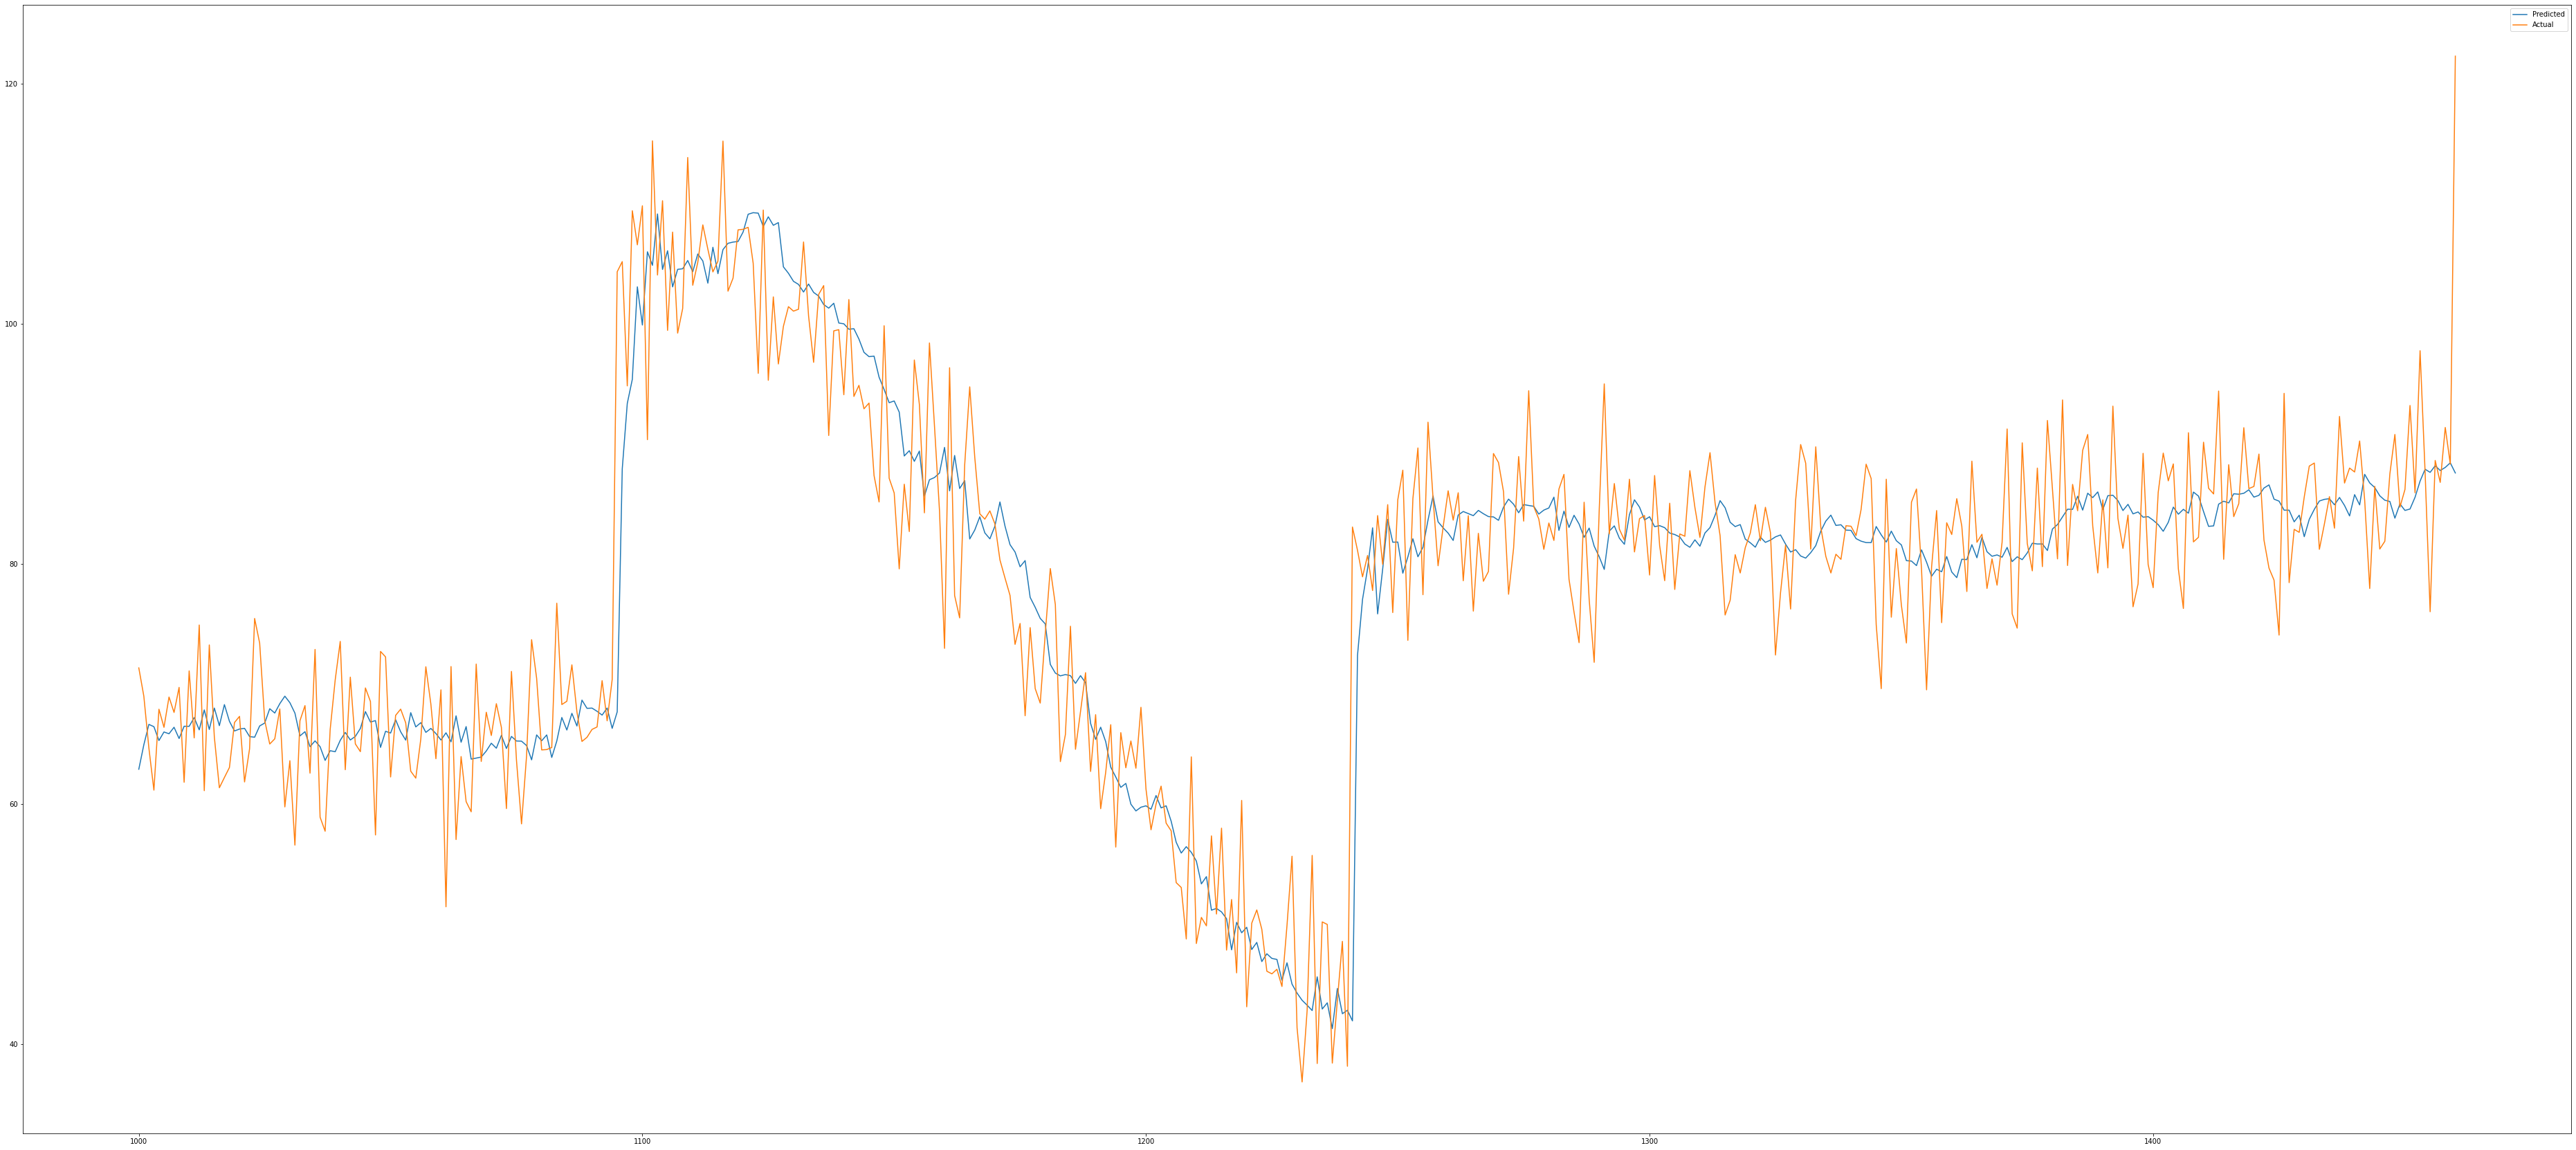

In [143]:
forecast = model_forecast(model,series[...,np.newaxis],WINDOW_SIZE,batch_size=1)

forecast = forecast[split_time-WINDOW_SIZE:-1,-1]
forecase = forecast.flatten()


plt.figure(figsize=(66,30))
plt.plot(val_time,forecast,label='Predicted')
plt.plot(val_time,val_series,label='Actual')
plt.legend()